In [1]:
# Step 1: Install required packages
%pip install imbalanced-learn

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Step 2: Upload your file (if not in Colab storage)
from google.colab import files
uploaded = files.upload()

# Replace with your actual file name if different
df = pd.read_csv('churn_model.csv')

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


Saving churn_model.csv to churn_model (1).csv
✅ Dataset loaded successfully!
Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Step 3: Basic info
print("Dataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nStatistical Summary:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Missing Values:
RowNumber          0
CustomerId         0
Surname         

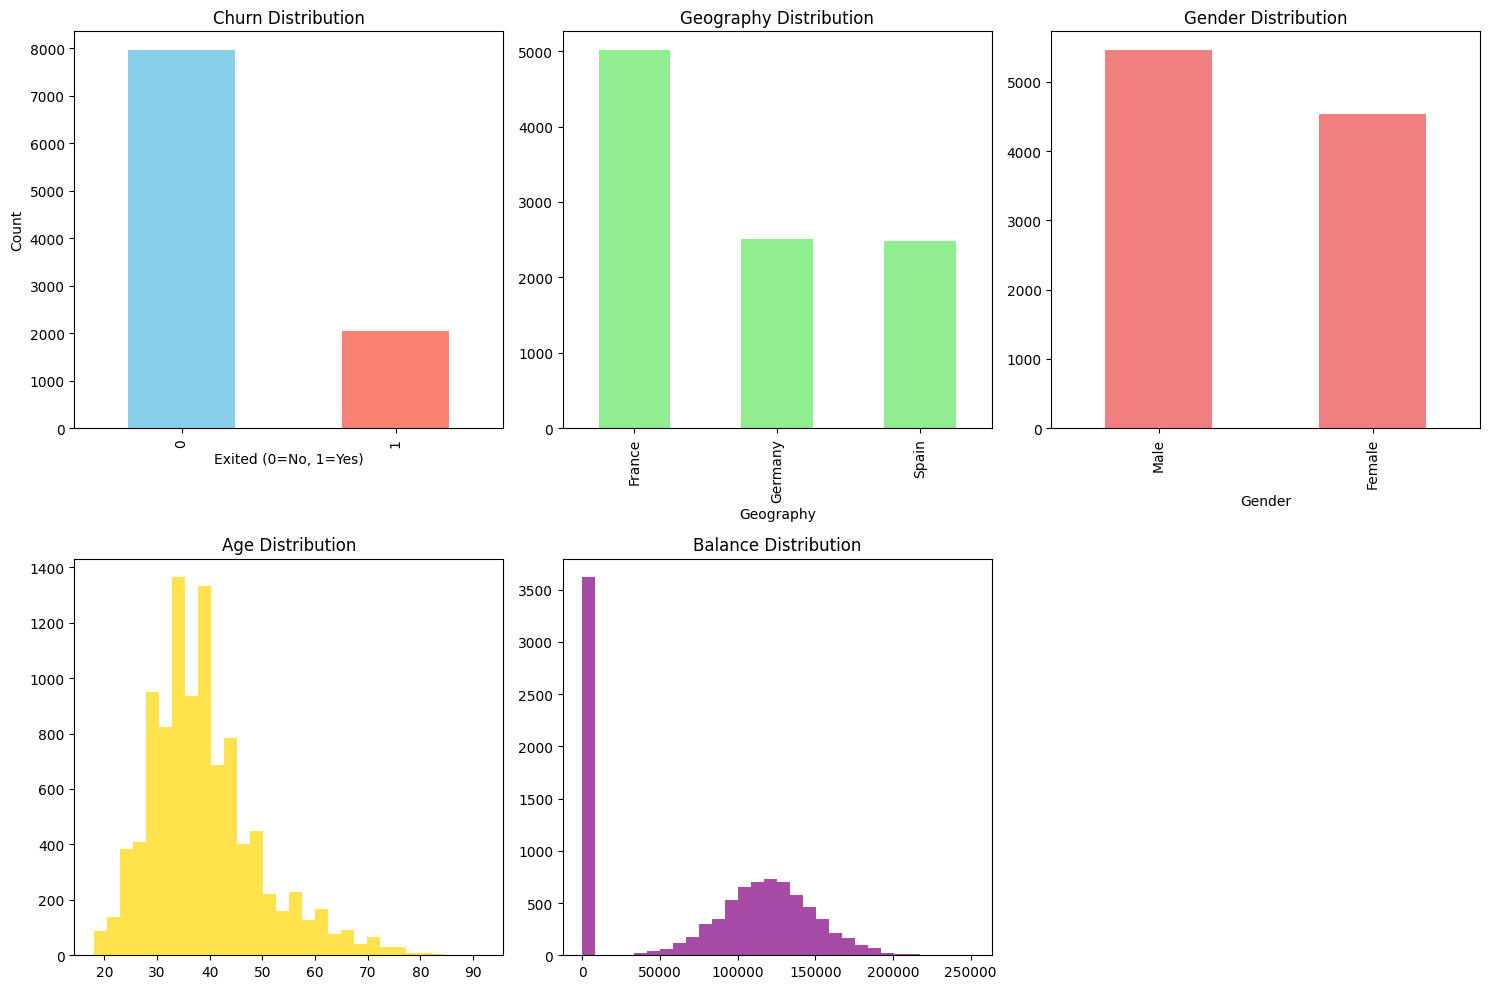

In [5]:
# Step 4: Exploratory data analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df['Exited'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.xlabel('Exited (0=No, 1=Yes)')
plt.ylabel('Count')

plt.subplot(2, 3, 2)
df['Geography'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Geography Distribution')

plt.subplot(2, 3, 3)
df['Gender'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Gender Distribution')

plt.subplot(2, 3, 4)
plt.hist(df['Age'], bins=30, color='gold', alpha=0.7)
plt.title('Age Distribution')

plt.subplot(2, 3, 5)
plt.hist(df['Balance'], bins=30, color='purple', alpha=0.7)
plt.title('Balance Distribution')

plt.tight_layout()
plt.show()


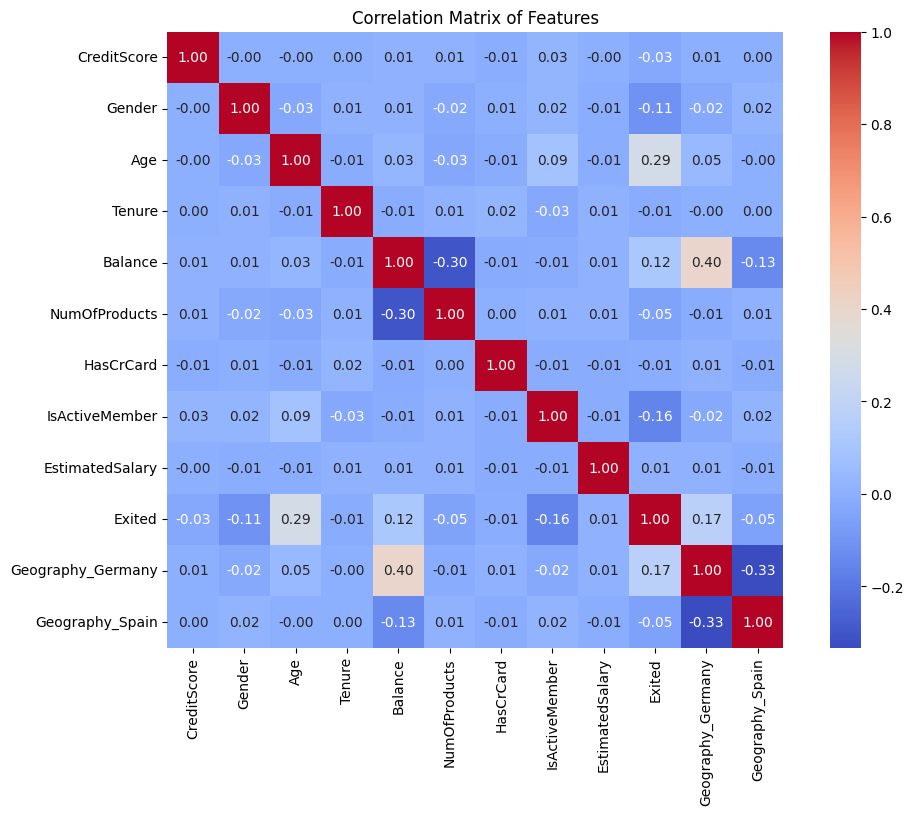


Correlation with 'Exited':
Exited               1.000000
Age                  0.285323
Geography_Germany    0.173488
Balance              0.118533
EstimatedSalary      0.012097
HasCrCard           -0.007138
Tenure              -0.014001
CreditScore         -0.027094
NumOfProducts       -0.047820
Geography_Spain     -0.052667
Gender              -0.106512
IsActiveMember      -0.156128
Name: Exited, dtype: float64


In [12]:
# Step 4.5: Correlation Matrix
plt.figure(figsize=(12, 8))
corr = df.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Features")
plt.show()

# Optionally, show correlation of each feature with target
print("\nCorrelation with 'Exited':")
print(corr['Exited'].sort_values(ascending=False))


In [18]:
# Step 5: Handle categorical data
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
# df = pd.get_dummies(df, columns=['Geography'], drop_first=True) # This line is redundant

# Drop unnecessary columns
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(cols_to_drop, axis=1, errors='ignore')

print("✅ Data Preprocessing Done")
display(df.head())

✅ Data Preprocessing Done


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


In [19]:
# Step 6: Split features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Data Split Complete")


✅ Data Split Complete


In [20]:
# Step 7: Handle class imbalance
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("✅ SMOTE applied successfully")


✅ SMOTE applied successfully


In [21]:
# Step 8: Train multiple models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True)
}

results = {}

for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    acc = model.score(X_test, y_test)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

results


Logistic Regression Accuracy: 0.7475
Decision Tree Accuracy: 0.7630
Random Forest Accuracy: 0.8315
Gradient Boosting Accuracy: 0.8205
SVM Accuracy: 0.4520


{'Logistic Regression': 0.7475,
 'Decision Tree': 0.763,
 'Random Forest': 0.8315,
 'Gradient Boosting': 0.8205,
 'SVM': 0.452}


🏆 Best Model: Random Forest

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      1607
           1       0.56      0.65      0.60       393

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.84      2000



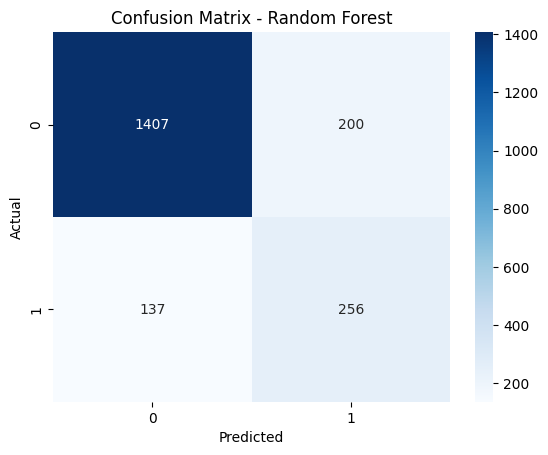

In [22]:
# Step 9: Evaluate the best performing model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}\n")

y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


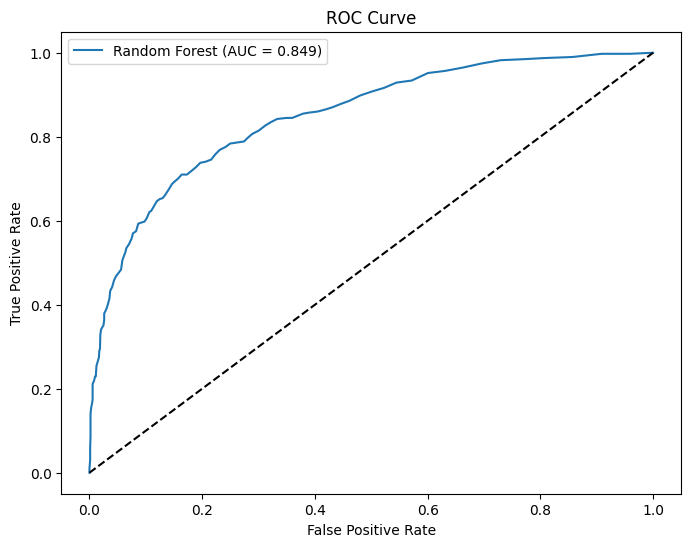

In [23]:
# Step 10: ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_prob):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


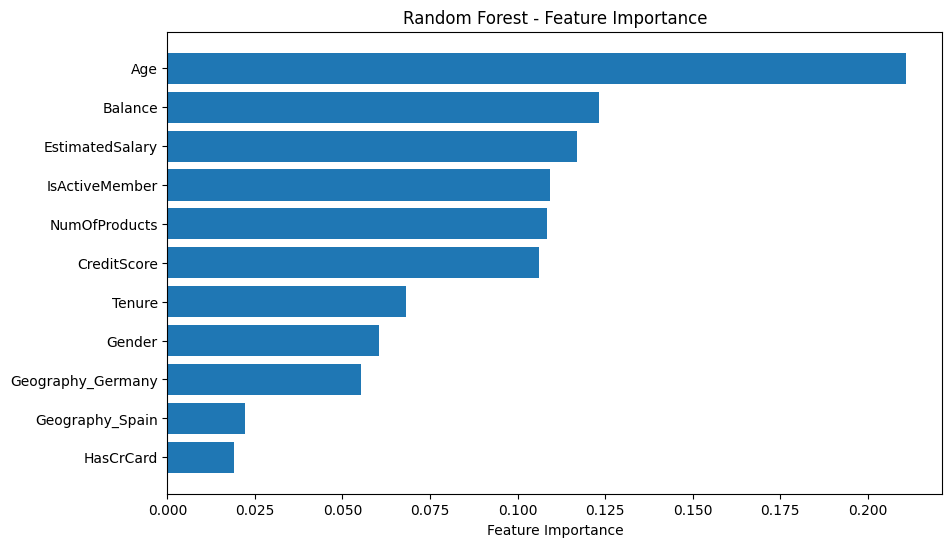

In [24]:
importances = best_model.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title(f"{best_model_name} - Feature Importance")
plt.gca().invert_yaxis()
plt.show()
